In [1]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 25.3 MB/s 
     |████████████████████████████████| 212 kB 64.9 MB/s 


In [48]:
 

%matplotlib inline

import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt
import nlp

import random

def show_history(h):
  epochs_trained = len(h.history['loss'])
    
  plt.figure(figsize = (10,6))
  plt.subplot(1, 2, 1) 
  plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
  plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
  plt.ylim([0. , 1.])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  
  plt.subplot(1, 2, 2)  
  plt.plot(range(0, epochs_trained), h.history.get('loss'), label = 'Training')
  plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label = 'Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

def show_confusion_matrix(y_true,y_pred,classes):
  from sklearn.metrics import confusion_matrix 
  cm = confusion_matrix(y_true,y_pred,normalize = 'true')
  plt.figure(figsize = (8,8))
  sp = plt.subplot(1,1,1)
  ctx = sp.matshow(cm)
  plt.xticks (list(range(0,6)) , labels = classes)   
  plt.yticks (list(range(0,6)), labels = classes)
  plt.colorbar(ctx)
  plt.show()

print(tf.__version__)
 


2.9.2


In [3]:
dataset = nlp.load_dataset('emotion')


Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [6]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets,labels

In [7]:
tweets,labels = get_tweet(train)

In [8]:
tweets[1] , labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer


In [10]:
tokenizer = Tokenizer(num_words = 10000, oov_token = '<OOV>')
tokenizer.fit_on_texts(tweets)


In [11]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

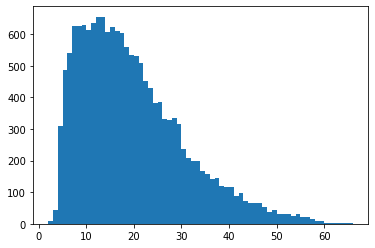

In [12]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths,bins = len(set(lengths)))
plt.show()


In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = 60

In [14]:
def get_sequences(tokenizer,tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences,truncating = 'post',padding = 'post', maxlen=maxlen)
  return padded

In [15]:
padded_train_seq = get_sequences(tokenizer,tweets)  

In [16]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [25]:
classes = set(labels)
print(classes)

{'fear', 'sadness', 'surprise', 'joy', 'anger', 'love'}


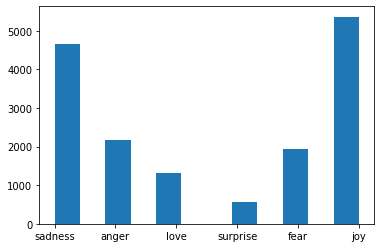

In [19]:
plt.hist(labels,bins =12)
plt.show()

In [26]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())


In [24]:
class_to_index

{'fear': 0, 'sadness': 1, 'surprise': 2, 'joy': 3, 'anger': 4, 'love': 5}

In [27]:
index_to_class

{0: 'fear', 1: 'sadness', 2: 'surprise', 3: 'joy', 4: 'anger', 5: 'love'}

In [28]:
name_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [30]:
train_labels = name_to_ids(labels)
print(train_labels)

[1 1 4 ... 3 4 1]


In [34]:
# model creation 
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,16,input_length = maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences =True)), # the context of LSTM is from right to left and vice-versa 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation = 'softmax')

])
#compiling the model
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 60, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


#Training and validation


In [36]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = name_to_ids(val_labels)

In [38]:
himanshu = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq,val_labels),
    epochs = 20,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor ='val_accuracy', patience =2)
    ]

)

Epoch 1/20
500/500 [==============================] - 17s 17ms/step - loss: 1.3962 - accuracy: 0.3768 - val_loss: 1.1625 - val_accuracy: 0.4615
Epoch 2/20
500/500 [==============================] - 7s 14ms/step - loss: 0.9944 - accuracy: 0.5626 - val_loss: 0.8569 - val_accuracy: 0.6905
Epoch 3/20
500/500 [==============================] - 7s 13ms/step - loss: 0.6237 - accuracy: 0.7484 - val_loss: 0.6718 - val_accuracy: 0.7225
Epoch 4/20
500/500 [==============================] - 7s 13ms/step - loss: 0.4429 - accuracy: 0.8124 - val_loss: 0.6033 - val_accuracy: 0.7930
Epoch 5/20
500/500 [==============================] - 7s 13ms/step - loss: 0.3029 - accuracy: 0.8969 - val_loss: 0.5402 - val_accuracy: 0.8410
Epoch 6/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2181 - accuracy: 0.9309 - val_loss: 0.5570 - val_accuracy: 0.8300
Epoch 7/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1574 - accuracy: 0.9528 - val_loss: 0.5046 - val_accuracy: 0.853

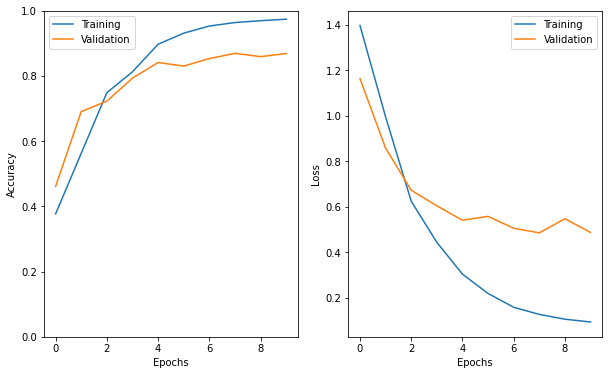

In [49]:
# evaluating the model 
show_history(himanshu)

In [52]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = name_to_ids(test_labels)


In [53]:
_ = model.evaluate(test_seq,test_labels)

63/63 [==============================] - 1s 8ms/step - loss: 0.4554 - accuracy: 0.8695


In [55]:
 

i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

 

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype("uint8")]

print('Predicted Emotion:', pred_class)


Sentence: i feel like i m part of the problem when i call out missy jane s trusting an angel cover for not airbrushing out all the real skin on the cover model s
Emotion: joy
1/1 [==============================] - 1s 1s/step
Predicted Emotion: joy


In [62]:
preds = np.argmax(model.predict(test_seq),axis =1)

63/63 [==============================] - 0s 7ms/step


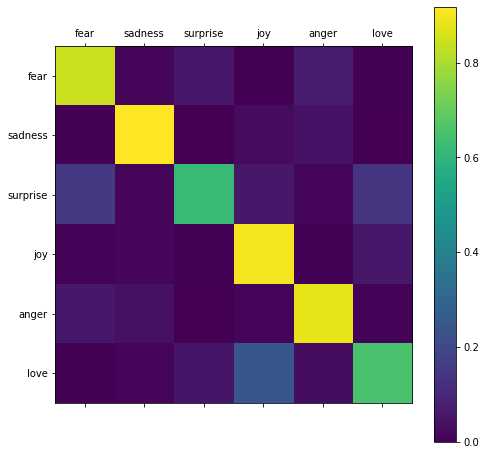

In [63]:
show_confusion_matrix(test_labels,preds,list(classes))